## Regressão linear de dados completos

Nesse notebook fazemos a regressão linear análoga à que tínhamos feitos com os dados de SP apenas, mas agora com os dados dos outros estados. Primeiro fazemos com os dados agrupados e depois com os desagrupados. 

In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

### A regressão

Aqui definimos a função que faz todos os modelos de regressçao linear e retorna as métricas que serão usadas para avaliar para quais doencas o modelo teve um bom desempenho.

In [8]:
def regressao(X, y):
    
    # vetor que guarda os valores do mean absolute error
    mae_v = []

    # colodando em [0,1]
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y)

    # 3-fold cross validation
    kf = KFold(n_splits=3)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # regressão Linear 
        reg = LinearRegression().fit(X_train, y_train)
        y_hat = reg.predict(X_test)
        mae_v.append(mean_absolute_error(y_test, y_hat))
        
    # calculando o erro absoluto medio final
    mae = np.mean(mae_v)
    return mae

## Desagrupados

In [9]:
desagrupados = pd.read_csv('../../../dados/formatado_desagrupado.csv', sep = ';')
desagrupados.sample(5)

cod_muni  qtd_mora  incidencia diag_princ  prevalencia  \
103816    314505      7371           2       K319     0.000271   
101716    314380      6242          67       J189     0.010734   
137627    317060      2158           2       K403     0.000927   
229673    355250    261260          10       J339     0.000038   
220838    354780    673064          14       K449     0.000021   

        renda_media_mora  SITU1_entorno  SITU2_entorno  SITU3_entorno  \
103816          0.103324       0.370242       0.196738            0.0   
101716          0.168766       0.540596       0.000000            0.0   
137627          0.234856       0.527569       0.000000            0.0   
229673          0.294240       0.965395       0.000000            0.0   
220838          0.617402       0.995818       0.004182            0.0   

        SITU4_entorno  ...  V032_domicilio02  V033_domicilio02  \
103816       0.000000  ...          0.110435          0.364828   
101716       0.000000  ...          0.212242          0.050344   
137627       0.000000  ...          0.057790          0.193712   
229673       0.002691  ...          0.019518          0.008580   
220838       0.000000  ...          0.060218          0.000062   

        V034_domicilio02  V035_domicilio02  V036_domicilio02  \
103816          0.007975          0.030279          0.001216   
101716          0.001438          0.000799          0.000799   
137627          0.017568          0.011096          0.000000   
229673          0.001006          0.001581          0.000099   
220838          0.000019          0.000708          0.000096   

        V037_domicilio02  V038_domicilio02  V041_domicilio02  \
103816          0.006759          0.988240          0.008110   
101716          0.001438          0.994246          0.003356   
137627          0.029589          0.988442          0.009246   
229673          0.001227          0.992327          0.003025   
220838          0.000117          0.994772          0.000285   

        V045_domicilio02  V089_domicilio02  
103816          0.512030          0.487970  
101716          0.518939          0.481061  
137627          0.529357          0.470643  
229673          0.490300          0.509700  
220838          0.479679          0.520321  

[5 rows x 83 columns]

### Seleção de doenças

Primeiro fazemos uma seleção das doenças que fazem sentido serem analisadas, para isso usamos a lógica que uma doença com menos do que X casos não tem sentido ser analisada. 

No contexto específico, definimos uma variável "cutoff_incidencia" que define qual é o X para qual as doenças com menos casos do que esse número serão ignoradas

In [10]:
# acho que 1000 é um numero muito alto ainda
cutoff_incidencia = 1000

doencas_incidencia = desagrupados.groupby(['diag_princ']).sum()[['incidencia']]
doencas_incidencia.head(5)

incidencia
diag_princ            
J00                141
J010               257
J011                63
J012                76
J013               221

In [11]:
doencas_selected = doencas_incidencia[doencas_incidencia['incidencia'] >= cutoff_incidencia]
doencas_selected.head(5)

incidencia
diag_princ            
J030              3851
J039             11920
J040             12116
J042             14575
J060              1503

### Análise e resultados

Nesse bloco chamamos a função da regressão para as doenças selecionadas, fazendo a comparação entre uso ou não do PCA.

In [12]:
mae = [] # sem pca
mae_pca = [] # com pca

lista_inci = doencas_selected.reset_index()['diag_princ'].unique()
for doenca in lista_inci:
    df = desagrupados[desagrupados['diag_princ'] == doenca].copy()

    y = df[['prevalencia']].to_numpy()
    X = df[df.columns[5:]].to_numpy()
    mae.append(regressao(X, y))

    pca = PCA(n_components=25)
    X_pca = pca.fit_transform(X)
    mae_pca.append(regressao(X_pca, y))

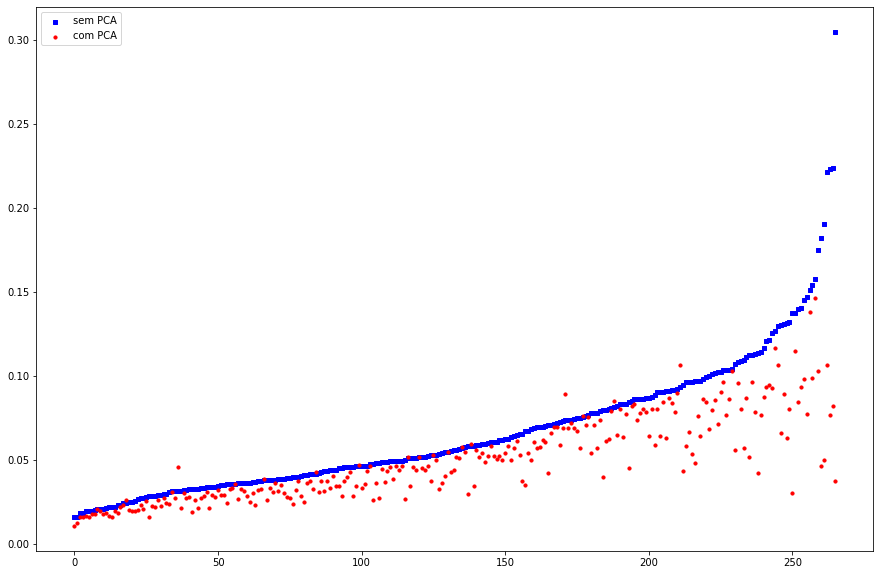

In [13]:
# Mean absolute error Sorted 
ms, msp = zip(*sorted(zip(mae, mae_pca)))

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)

ax1.scatter(range(len(ms)), ms, s=10, c='b', marker="s", label='sem PCA')
ax1.scatter(range(len(msp)), msp, s=10, c='r', marker="o", label='com PCA')
plt.legend(loc='upper left')
plt.show()

### Doenças com maiores incidencia

Aqui, fazemos a mesma analise de cima, mas olhamos para as doenças com maior prevalencia

In [14]:
doencas_preva = desagrupados.groupby(['diag_princ']).sum()[['qtd_mora', 'incidencia']]
doencas_preva.head(5)

qtd_mora  incidencia
diag_princ                      
J00         18086097         141
J010        27705040         257
J011        13619685          63
J012        15978849          76
J013        26223496         221

In [15]:
# prevalencia 
doencas_preva['prevalencia'] = doencas_preva['incidencia'] / doencas_preva['qtd_mora']
doencas_preva.head(5)

qtd_mora  incidencia  prevalencia
diag_princ                                   
J00         18086097         141     0.000008
J010        27705040         257     0.000009
J011        13619685          63     0.000005
J012        15978849          76     0.000005
J013        26223496         221     0.000008

In [16]:
lista_doencas = doencas_preva.reset_index()[['diag_princ', 'prevalencia']].to_numpy()
print(lista_doencas)

[['J00' 7.796043557656469e-06]
 ['J010' 9.276290523312725e-06]
 ['J011' 4.625657641861761e-06]
 ...
 ['K930' 5.1802135680815075e-06]
 ['K931' 3.2434884582482745e-05]
 ['K938' 0.00012554216908597994]]


In [17]:
# sorteando pela segunda coluna, da maior para menor
ls = lista_doencas[lista_doencas[:,1].argsort()[::-1]]
print(ls)

[['J189' 0.007870525744004547]
 ['J180' 0.0037088795201337082]
 ['J459' 0.003353264262738317]
 ...
 ['J991' 4.2310634524123833e-07]
 ['K005' 4.2310634524123833e-07]
 ['K003' 3.7538636641763534e-07]]


In [18]:
lista_preva = ls[:,0]
print(lista_preva)

['J189' 'J180' 'J459' 'K409' 'J449' 'J158' 'J188' 'K359' 'J960' 'K429'
 'J159' 'K810' 'K808' 'K800' 'K802' 'J219' 'J353' 'K928' 'K403' 'K929'
 'J128' 'K439' 'K805' 'J110' 'K297' 'J068' 'K564' 'J342' 'J440' 'K920'
 'J81' 'K746' 'J448' 'K811' 'J181' 'K703' 'K801' 'K566' 'J46' 'J218'
 'K818' 'K054' 'K921' 'K402' 'J40' 'J352' 'K819' 'K291' 'J210' 'J36'
 'J441' 'K420' 'K351' 'K350' 'J042' 'K650' 'J129' 'K603' 'K299' 'J359'
 'J100' 'K36' 'J90' 'J350' 'J168' 'K868' 'J938' 'K590' 'K638' 'K861'
 'J040' 'J039' 'K529' 'J154' 'K869' 'K469' 'K804' 'K639' 'K430' 'J351'
 'K859' 'K610' 'K768' 'K319' 'J450' 'J439' 'K658' 'K729' 'K318' 'K769'
 'K460' 'J13' 'K565' 'J80' 'J942' 'J969' 'K550' 'K938' 'K579' 'K404'
 'K598' 'K389' 'K828' 'J153' 'J929' 'K30' 'J930' 'K831' 'J984' 'K830'
 'J343' 'K900' 'K400' 'J42' 'K419' 'K296' 'J358' 'J458' 'K388' 'K860'
 'K20' 'K720' 'K279' 'J381' 'K745' 'K219' 'J371' 'J931' 'J152' 'J390'
 'K659' 'J030' 'J703' 'K210' 'K839' 'K591' 'K750' 'K838' 'K701' 'K851'
 'K858' 'K709' 'K

In [19]:
mae = [] # sem pca
mae_pca = [] # com pca
labels = []

for doenca in lista_preva[:100]:
    df = desagrupados[desagrupados['diag_princ'] == doenca].copy()
    if (df.shape[0] < 5): continue # ignora menos que 5 linhas

    y = df[['prevalencia']].to_numpy()
    X = df[df.columns[5:]].to_numpy()
    mae.append(regressao(X, y))

    pca = PCA(n_components=25)
    X_pca = pca.fit_transform(X)
    mae_pca.append(regressao(X_pca, y))

    labels.append(doenca)

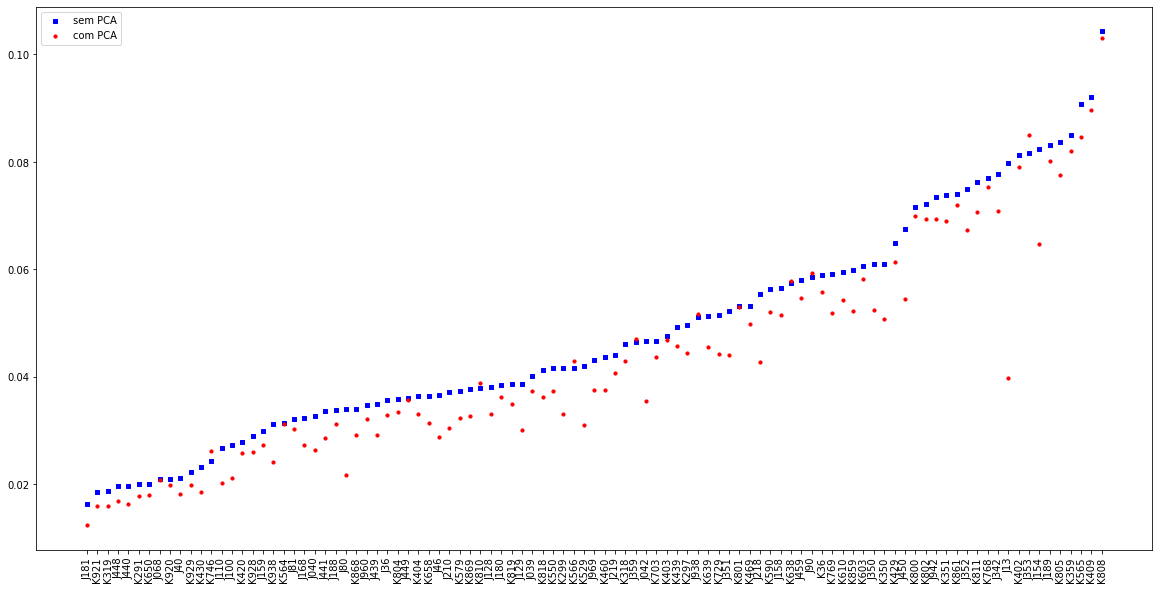

In [20]:
# Mean absolute error Sorted 
ms, msp, labels = zip(*sorted(zip(mae, mae_pca, labels)))
sz = len(ms)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.scatter(range(sz), ms, s=10, c='b', marker="s", label='sem PCA')
ax1.scatter(range(sz), msp, s=10, c='r', marker="o", label='com PCA')

plt.xticks(range(sz), labels, rotation='vertical')
plt.legend(loc='upper left')
plt.show()

## Doenças com maior prevalencia e incidencia

Aqui, cruzamos a lista de doenças com maior incidencia com as de maior prevalencia. Tentando obter o melhor dos dois mundos

In [21]:
lista = []
for d in lista_preva:
    if d in lista_inci:
        lista.append(d)
print(lista)

['J189', 'J180', 'J459', 'K409', 'J449', 'J158', 'J188', 'K359', 'J960', 'K429', 'J159', 'K810', 'K808', 'K800', 'K802', 'J219', 'J353', 'K928', 'K403', 'K929', 'J128', 'K439', 'K805', 'J110', 'K297', 'J068', 'K564', 'J342', 'J440', 'K920', 'J81', 'K746', 'J448', 'K811', 'J181', 'K703', 'K801', 'K566', 'J46', 'J218', 'K818', 'K921', 'K402', 'J40', 'J352', 'K819', 'K291', 'J210', 'J36', 'J441', 'K420', 'K351', 'K350', 'J042', 'K650', 'J129', 'K603', 'K299', 'J359', 'J100', 'K36', 'J90', 'J350', 'J168', 'K868', 'J938', 'K590', 'K638', 'K861', 'J040', 'J039', 'K529', 'J154', 'K869', 'K469', 'K804', 'K639', 'K430', 'J351', 'K859', 'K610', 'K768', 'K319', 'J450', 'J439', 'K658', 'K729', 'K318', 'K769', 'K460', 'J13', 'K565', 'J80', 'J942', 'J969', 'K550', 'K938', 'K579', 'K404', 'K598', 'K389', 'K828', 'J153', 'K30', 'J930', 'K831', 'J984', 'K830', 'J343', 'K900', 'K400', 'J42', 'K419', 'K296', 'J358', 'J458', 'K388', 'K860', 'K20', 'K720', 'K279', 'J381', 'K745', 'K219', 'J371', 'J931', 'J

In [22]:
mae = [] # sem pca
mae_pca = [] # com pca
labels = []

for doenca in lista[:min(100, len(lista))]:
    df = desagrupados[desagrupados['diag_princ'] == doenca].copy()
    if (df.shape[0] < 5): continue # ignora menos que 5 linhas

    y = df[['prevalencia']].to_numpy()
    X = df[df.columns[5:]].to_numpy()
    mae.append(regressao(X, y))

    pca = PCA(n_components=25)
    X_pca = pca.fit_transform(X)
    mae_pca.append(regressao(X_pca, y))

    labels.append(doenca)

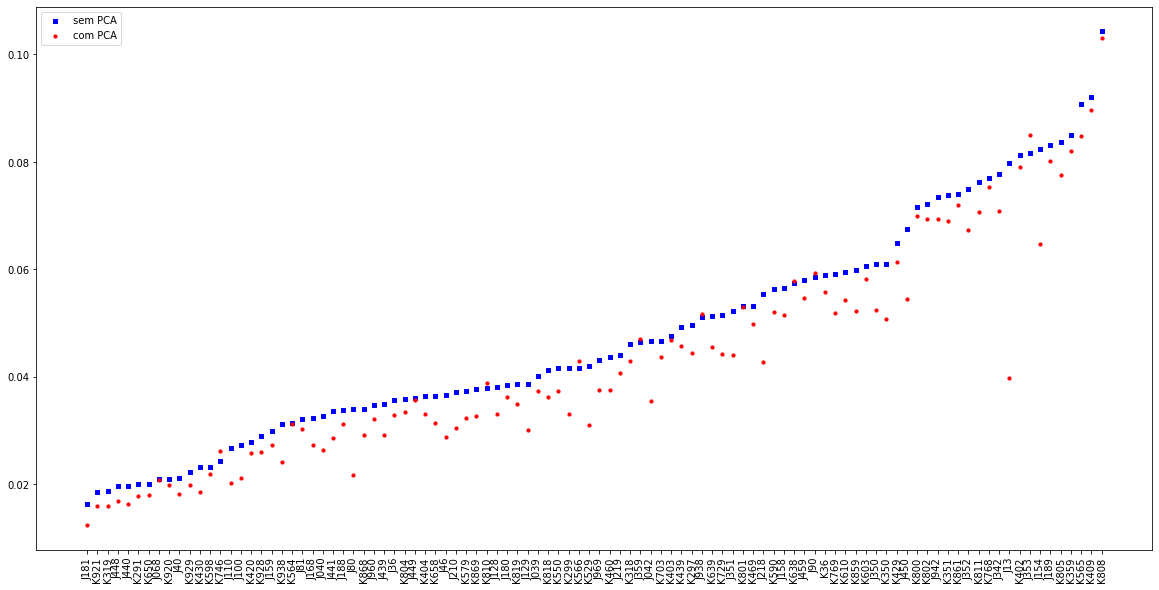

In [23]:
# Mean absolute error Sorted 
ms, msp, labels = zip(*sorted(zip(mae, mae_pca, labels)))
sz = len(ms)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.scatter(range(sz), ms, s=10, c='b', marker="s", label='sem PCA')
ax1.scatter(range(sz), msp, s=10, c='r', marker="o", label='com PCA')

plt.xticks(range(sz), labels, rotation='vertical')
plt.legend(loc='upper left')
plt.show()

## Agrupados

In [24]:
agrupados = pd.read_csv('../../../dados/formatado_agrupados.csv', sep = ';')
agrupados.sample(5)

cod_muni  qtd_mora  incidencia diag_princ  prevalencia  \
99826     353960      4418          24        K35     0.005432   
118688    430510    432439         408        K70     0.000944   
126032    431130     26750           1        K05     0.000037   
126496    431173      3003           6        K43     0.001998   
128646    431335      3329          11        K92     0.003304   

        renda_media_mora  SITU1_entorno  SITU2_entorno  SITU3_entorno  \
99826           0.284461       0.858874       0.000000       0.000000   
118688          0.616899       0.917123       0.048376       0.000000   
126032          0.376530       0.892896       0.000000       0.000000   
126496          0.173459       0.050346       0.092794       0.061204   
128646          0.497567       0.524085       0.000000       0.000000   

        SITU4_entorno  ...  V032_domicilio02  V033_domicilio02  \
99826        0.000000  ...          0.022631          0.122563   
118688       0.001715  ...          0.181227          0.006562   
126032       0.000000  ...          0.026449          0.050717   
126496       0.000000  ...          0.000000          0.065268   
128646       0.000000  ...          0.007179          0.153455   

        V034_domicilio02  V035_domicilio02  V036_domicilio02  \
99826           0.008066          0.004705          0.000000   
118688          0.001472          0.000620          0.000023   
126032          0.012134          0.001090          0.000291   
126496          0.003663          0.000666          0.000000   
128646          0.046066          0.001197          0.000000   

        V037_domicilio02  V038_domicilio02  V041_domicilio02  \
99826           0.002465          0.989693          0.000224   
118688          0.004932          0.992222          0.000604   
126032          0.003233          0.968610          0.003233   
126496          0.000999          0.992341          0.007659   
128646          0.001197          0.994915          0.000897   

        V045_domicilio02  V089_domicilio02  
99826           0.518261          0.481739  
118688          0.490426          0.509574  
126032          0.492788          0.507212  
126496          0.516483          0.483517  
128646          0.510918          0.489082  

[5 rows x 83 columns]

### Seleção e análise de resultados

Mesma análise de doenças principais e mesmas análises de resultados do caso anterior.

In [25]:
# acho que 1000 é um numero muito alto ainda
cutoff_incidencia = 1000

doencas_incidencia = agrupados.groupby(['diag_princ']).sum()[['incidencia']]
doencas_incidencia.head(5)

incidencia
diag_princ            
J0                 142
J01               1754
J02                177
J03              15803
J04              27626

In [26]:
doencas_selected = doencas_incidencia[doencas_incidencia['incidencia'] >= cutoff_incidencia]
doencas_selected.head(5)

incidencia
diag_princ            
J01               1754
J03              15803
J04              27626
J06              40632
J1                6302

In [27]:
mae = [] # sem pca
mae_pca = [] # com pca

for doenca in doencas_selected.reset_index()['diag_princ'].unique():
    df = agrupados[agrupados['diag_princ'] == doenca].copy()

    y = df[['prevalencia']].to_numpy()
    X = df[df.columns[5:]].to_numpy()
    mae.append(regressao(X, y))

    pca = PCA(n_components=25)
    X_pca = pca.fit_transform(X)
    mae_pca.append(regressao(X_pca, y))

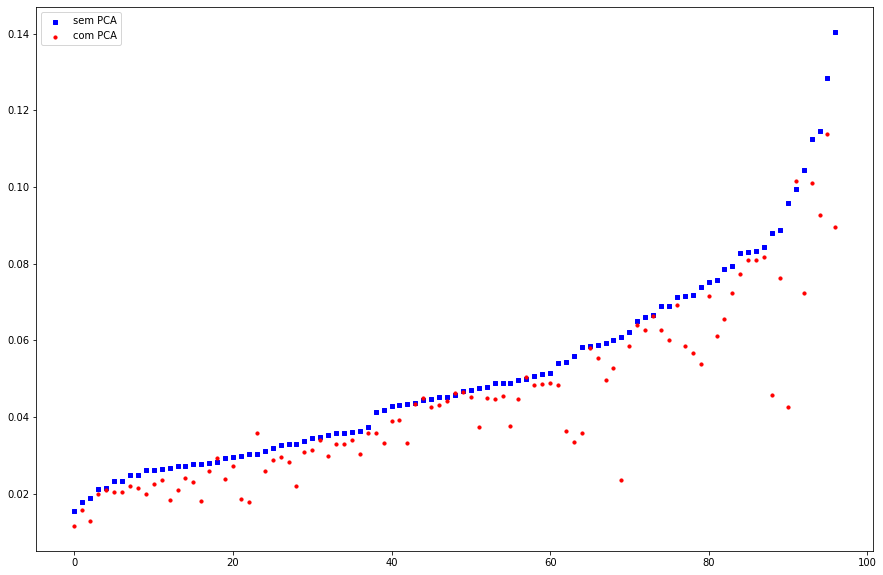

In [28]:
# Mean absolute error Sorted 
ms, msp = zip(*sorted(zip(mae, mae_pca)))

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)

ax1.scatter(range(len(ms)), ms, s=10, c='b', marker="s", label='sem PCA')
ax1.scatter(range(len(msp)), msp, s=10, c='r', marker="o", label='com PCA')
plt.legend(loc='upper left')
plt.show()